In [5]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
from keras.layers.core import Activation
from keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from keras.optimizers import RMSprop
from keras.utils import np_utils
from tensorflow.compat.v1.keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose

In [21]:
f_data = r'C:\Users\fe73yap\Downloads\Train_data_FLINET' # Directory with trainging data
stacks = os.listdir(f_data)
numS = int(len(stacks))

nTG = 256 # Number of time-points
xX = 28
yY = 28

tpsfD = np.ndarray(
        (numS, int(nTG), int(xX), int(yY), int(1)), dtype=np.float32
        )
t1 = np.ndarray(
        (numS, int(xX), int(yY), int(1)), dtype=np.float32
        )
t2 = np.ndarray(
        (numS, int(xX), int(yY), int(1)), dtype=np.float32
        )
tR = np.ndarray(
        (numS, int(xX), int(yY), int(1)), dtype=np.float32
        )

i = 0;
for d in stacks:
    #Save values to respective mapping
    f = h5py.File(os.path.join(f_data,d),'r') 
    tpsfD[i,:,:,:,0] = f.get('sigD')
    f = h5py.File(os.path.join(f_data,d),'r') 
    t1[i,:,:,0] = f.get('t1')
    f = h5py.File(os.path.join(f_data,d),'r') 
    t2[i,:,:,0] = f.get('t2')
    f = h5py.File(os.path.join(f_data,d),'r') 
    tR[i,:,:,0] = f.get('rT')
    i = i + 1
    
tpsfD =  np.moveaxis(tpsfD, 1, -2)

In [ ]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
tpsfD.shape

In [7]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [31]:
modelD = None
xX = 28;
yY = 28;

t_data = Input(shape=(xX, yY, 256,1))
tpsf = t_data

# # # # # # # # 3D-Model # # # # # # # #

tpsf = Conv3D(50,kernel_size=(1,1,10),strides=(1,1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_3D_BN(50, (1,1,5), tpsf)
tpsf = Reshape((xX,yY,2600))(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)

# Short-lifetime branch
imgT1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(32, 1, padding='same', activation=None)(imgT1)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(1, 1, padding='same', activation=None)(imgT1)
imgT1 = Activation('relu')(imgT1)

# Long-lifetime branch
imgT2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(32, 1, padding='same', activation=None)(imgT2)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(1, 1, padding='same', activation=None)(imgT2)
imgT2 = Activation('relu')(imgT2)

# Amplitude-Ratio branch
imgTR = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Conv2D(32, 1, padding='same', activation=None)(imgTR)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Conv2D(1, 1, padding='same', activation=None)(imgTR)
imgTR = Activation('relu')(imgTR)

modelD = Model(inputs=[t_data], outputs=[imgT1,imgT2, imgTR])
rmsprop = RMSprop(lr=1e-5)

modelD.compile(loss='mse',
              optimizer=rmsprop,
              metrics=['mae'])
modelD.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 256  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_21 (Conv3D)             (None, 28, 28, 52,   550         ['input_8[0][0]']                
                                50)                                                               
                                                                                                  
 batch_normalization_57 (BatchN  (None, 28, 28, 52,   200        ['conv3d_21[0][0]']              
 ormalization)                  50)                                                         

                                                                  'activation_72[0][0]']          
                                                                                                  
 activation_74 (Activation)     (None, 28, 28, 256)  0           ['add_15[0][0]']                 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 28, 28, 64)   16448       ['activation_74[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 28, 28, 64)   16448       ['activation_74[0][0]']          
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 64)   16448       ['activation_74[0][0]']          
                                                                                                  
 batch_nor

In [78]:
# Setting patience (patience = 15 recommended)
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 15, 
                              verbose = 1,
                              mode = 'auto')

fN = 'testName' # Assign some name for weights and training/validation loss curves here

# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
history = History()
csv_logger = CSVLogger(fN+'.log')
tic = time.perf_counter()
history = modelD.fit([tpsfD], [t1,t2,tR],
          validation_split=0.2,
          batch_size=20, epochs=500, verbose=1, shuffle=True, callbacks=[earlyStopping,csv_logger,modelCheckPoint])
toc = time.perf_counter()
print(f" Training time {toc - tic:0.4f} seconds")

Epoch 1/500
4/4 [==============================] - 1s 137ms/step - loss: 3.1125 - activation_77_loss: 0.5236 - activation_80_loss: 2.3882 - activation_83_loss: 0.2006 - activation_77_mae: 0.3131 - activation_80_mae: 0.9437 - activation_83_mae: 0.2086 - val_loss: 2.5085 - val_activation_77_loss: 0.0486 - val_activation_80_loss: 2.3347 - val_activation_83_loss: 0.1252 - val_activation_77_mae: 0.1306 - val_activation_80_mae: 0.9213 - val_activation_83_mae: 0.1856
Epoch 2/500
4/4 [==============================] - 0s 87ms/step - loss: 2.9164 - activation_77_loss: 0.3618 - activation_80_loss: 2.3870 - activation_83_loss: 0.1676 - activation_77_mae: 0.2627 - activation_80_mae: 0.9435 - activation_83_mae: 0.1943 - val_loss: 2.5085 - val_activation_77_loss: 0.0487 - val_activation_80_loss: 2.3347 - val_activation_83_loss: 0.1252 - val_activation_77_mae: 0.1316 - val_activation_80_mae: 0.9213 - val_activation_83_mae: 0.1856
Epoch 3/500
4/4 [==============================] - 0s 87ms/step - loss:

Epoch 19/500
4/4 [==============================] - 0s 87ms/step - loss: 2.0284 - activation_77_loss: 0.0907 - activation_80_loss: 1.8517 - activation_83_loss: 0.0860 - activation_77_mae: 0.2048 - activation_80_mae: 0.8010 - activation_83_mae: 0.1487 - val_loss: 2.5085 - val_activation_77_loss: 0.0486 - val_activation_80_loss: 2.3347 - val_activation_83_loss: 0.1252 - val_activation_77_mae: 0.1300 - val_activation_80_mae: 0.9213 - val_activation_83_mae: 0.1856
Epoch 20/500
4/4 [==============================] - 0s 87ms/step - loss: 1.9743 - activation_77_loss: 0.0858 - activation_80_loss: 1.8039 - activation_83_loss: 0.0846 - activation_77_mae: 0.1955 - activation_80_mae: 0.7861 - activation_83_mae: 0.1473 - val_loss: 2.5085 - val_activation_77_loss: 0.0486 - val_activation_80_loss: 2.3347 - val_activation_83_loss: 0.1252 - val_activation_77_mae: 0.1300 - val_activation_80_mae: 0.9213 - val_activation_83_mae: 0.1856
Epoch 21/500
4/4 [==============================] - 0s 89ms/step - los

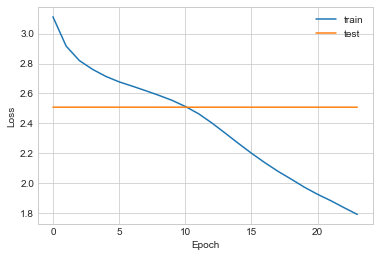

In [81]:
#plt.style.use('seaborn-whitegrid') 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Post-training: load "best" trained weights (obtained through patience - lowest value of loss)
# THIS CAN BE ANY WEIGHT FILE, AS LONG AS THE NETWORK ARCHITECTURE MATCHES THE ONE USED!
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

modelD.load_weights(fN+'.h5')

In [35]:
# Upload test data and use 3D-CNN for inference

t_data = r'C:\Users\fe73yap\Downloads\Train_data_FLINET' # directory with test data
stacksT = os.listdir(f_data)
numT = int(len(stacks))

nTG = 256
xX = 28
yY = 28

tpsfT = np.ndarray(
        (numT, int(nTG), int(xX), int(yY), int(1)), dtype=np.float32
        )
t1T = np.ndarray(
        (numT, int(xX), int(yY), int(1)), dtype=np.float32
        )
t2T = np.ndarray(
        (numT, int(xX), int(yY), int(1)), dtype=np.float32
        )
tRT = np.ndarray(
        (numT, int(xX), int(yY), int(1)), dtype=np.float32
        )

i = 0;
for d in stacksT:
    # Save values to respective mapping
    f = h5py.File(os.path.join(f_data,d),'r') 
    tpsfT[i,:,:,:,0] = f.get('sigD')
    f = h5py.File(os.path.join(f_data,d),'r') 
    t1T[i,:,:,0] = f.get('t1')
    f = h5py.File(os.path.join(f_data,d),'r') 
    t2T[i,:,:,0] = f.get('t2')
    f = h5py.File(os.path.join(f_data,d),'r') 
    tRT[i,:,:,0] = f.get('rT')
    i = i + 1
    
tpsfT =  np.moveaxis(tpsfT, 1, -2)
# tpsfT = np.moveaxis(tpsfT, 1, 2)

4/4 [==============================] - 0s 27ms/step


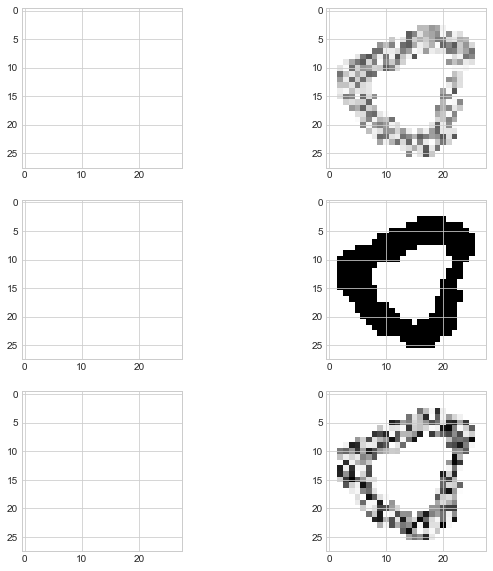

In [80]:
# Perform inference on test data with trained model
testV = modelD.predict(tpsfT)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
tRP = testV[2] # Predicted AR values

# Visualize example
n = 2 # Number to illustrate w/ matplotlib
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(3,2,1)
# Predicted tau1
ax1.imshow(t1P[n,:,:,0], interpolation='nearest', vmin=.2, vmax=.6)
ax2 = fig.add_subplot(3,2,2)
# G.T. tau1
ax2.imshow(t1T[n,:,:,0], interpolation='nearest', vmin=.2, vmax=.6)
ax3 = fig.add_subplot(3,2,3)
# Predicted tau2
ax3.imshow(t2P[n,:,:,0], interpolation='nearest', vmin=0.8, vmax=1.5)
# G.T. tau2
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(t2T[n,:,:,0], interpolation='nearest', vmin=.8, vmax=1.5)
# Predicted amplitude ratio
ax5 = fig.add_subplot(3,2,5)
ax5.imshow(tRP[n,:,:,0], interpolation='nearest', vmin=0, vmax=1)
# G.T. amplitude ratio
ax6 = fig.add_subplot(3,2,6)
ax6.imshow(tRT[n,:,:,0], interpolation='nearest', vmin=0, vmax=1)

In [39]:
testV 

[array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [46]:
t1P

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [47]:
t1T

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

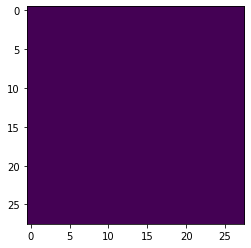

In [59]:
plt.imshow(t1P[2,:,:,0])
#ax2 = fig.add_subplot(3,2,2)

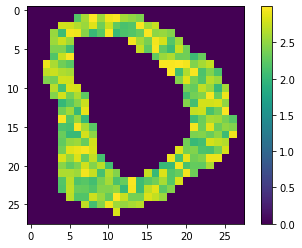

In [75]:
plt.imshow(t2T[50,:,:,0])
plt.colorbar()

In [67]:
t1P.shape

(100, 28, 28, 1)

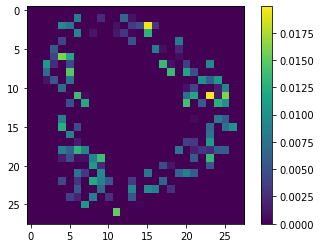

In [71]:
plt.imshow(tRP[50,:,:,0])
plt.colorbar()

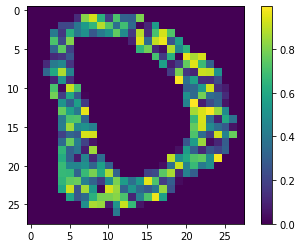

In [72]:
plt.imshow(tRT[50,:,:,0])
plt.colorbar()